# Разметка комментариев на токсичность

Интернет-магазин эксперементирует с новым сервисом - пользователи могут редактировать описания товаров по принципу wiki: предлагать свои правки и комментировать чужие. Чтобы упростить процесс утверждения правок, потребуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию человеку.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Балансировка-классов" data-toc-modified-id="Балансировка-классов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Балансировка классов</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Обучение-и-проверка-на-тестовой-выборке" data-toc-modified-id="Обучение-и-проверка-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение и проверка на тестовой выборке</a></span></li><li><span><a href="#Проверка-произвольных-текстов" data-toc-modified-id="Проверка-произвольных-текстов-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Проверка произвольных текстов</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Обзор данных

In [1]:
# Мы будем использовать skorch, а также нам понадобятся transformers версии не ниже 4.0.0
# %pip install skorch transformers --user

In [2]:
# Импортируем необходимые модули:
import re

import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, WeightedRandomSampler
from transformers import BertModel, BertTokenizer

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Зафиксируем состояние генератора случайных чисел для воспроизведения результатов:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE);

Ознакомимся с общей информацией и первыми строками таблицы:

In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.duplicated().sum()

0

### Вывод

В датасете 159571 комментарий и лишь два столбца: тексты (англоязычные) и соответствующая бинарная классификация. Нет ни дублированных строк, ни пропущенных значений. Чего еще в датасете нет, так это баланса классов: на положительный класс приходится лишь около 10% наблюдений.

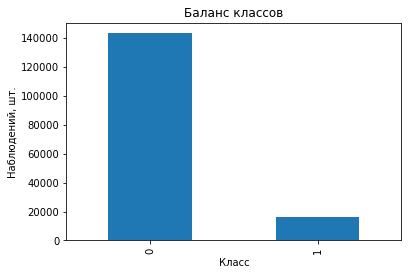

In [8]:
df['toxic'].value_counts().plot(kind='bar').set(title='Баланс классов', xlabel='Класс', ylabel='Наблюдений, шт.');

In [9]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

## Модель

### Подготовка выборок



Нашей модели не потребуется лемматизации, поскольку она обучена на естественных текстах, а токенизация позволяет превращать морфемы в токены. Тем не менее, небольшая чистка текста от лишних символов улучшает метрику с порогом классификации по умолчанию:

In [10]:
def clear_text(text):
    return ' '.join(re.sub(r"[^a-zA-Z '\.,-;:!?]",' ',text).split())

In [11]:
df['text'] = df['text'].apply(clear_text)

Поскольку техзадание оговаривает использование модели BERT, воспользуемся токенизатором из ее комплекта (без различия регистра):

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, use_fast=True)

Для более оптимальной обработки данных реализуем свой класс *Dataset* для torch:

In [13]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = [text for text in df['text']]
        self.labels = [label for label in df['toxic']]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        # Некоторые особенности последних версий библиотеки transformers:
        # Токенизировать данные заранее не рекомендуется: это мешает параллельной обработке.
        # Прямой вызов encode() или encode_plus() больше не требуется, достаточно метода __call__() токенизатора.
        # Он возвращает и токены, и attention mask.
        # Максимальная длина последовательности для BERT - 512 токенов, однако на практике можно использовать
        # первые 128. Увеличение максимальной длины сильно замедляет токенизацию при незначительном улучшении
        # метрики F1 (0.02-0.03).
        batch_tokens = tokenizer(batch_texts, padding='max_length', max_length=512,
                                 truncation=True, return_tensors="pt")
        # Багфикс от 04.02.22: c некоторыми версиями пакетов таргет оказывался не того типа (торч требует long).
        batch_labels = np.array(self.labels[idx]).astype('int64')
        return batch_tokens, batch_labels

Выделим тестовую выборку в размере 20% от датасета.

Также выделим небольшую валидационную выборку в размере 2% от общего объема (она понадобится только для быстрого мониторинга прогресса обучения).

In [14]:
df_train, df_valid_test = train_test_split(df, test_size=0.22, random_state=RANDOM_STATE)
df_test, df_valid = train_test_split(df_valid_test, test_size=0.1, random_state=RANDOM_STATE)

Загрузим выборки в экземпляры нашего класса:

In [15]:
train_set, val_set, test_set = MyDataset(df_train), MyDataset(df_valid), MyDataset(df_test)

### Балансировка классов

Поскольку мы используем torch, развесовку представляется оптимальным сделать с помощью *WeightedRandomSampler*, это же позволяет регулировать размер обучающей выборки для экспериментов.

In [16]:
# Вычислим веса классов:
class_weights = torch.DoubleTensor([len(df_train)/c for c in df_train['toxic'].value_counts().sort_index().values])
class_weights

tensor([1.1127, 9.8735], dtype=torch.float64)

Мы не будем загружать в модель обучающую выборку полностью: языковые трансформеры хорошо улавливают закономерности даже на небольшом количестве примеров, кроме того, за счет семплирования за 10 эпох обучения мы обеспечим модели количество примеров положительного класса, сравнимое с их общим числом в выборке, и столько же отрицательных примеров.

In [17]:
# .. и создадим соответствующий самплер (с возвращением):
sample_weights = df_train['toxic'].apply(lambda x: class_weights[x])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples = int(len(train_set)/40), replacement=True)

### Модель

Приматывать к BERT логистическую регрессию синей изолентой мы, конечно, не будем, вместо этого добавим к модели линейную часть, сводящую эмбеддинги к классам (то же самое делает, например, *BertForSequenceClassification*):

In [18]:
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super(BertBinaryClassifier, self).__init__()
        # Загрузим модель BERT:
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Добавим dropout, рандомно выключающий часть нейронных связей, чтобы модель не переобучалась:
        self.dropout = torch.nn.Dropout(0.5)
        # И будем сводить 768 выходных узлов BERT к 2 классам:
        self.linear = torch.nn.Linear(768, 2)

    # BERT ожидает на входе следующие именованные аргументы:
    def forward(self, input_ids, token_type_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids.squeeze(1), attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)

        return linear_output

In [19]:
model = BertBinaryClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Здесь можно поменять константы для даталоадера и обучения:
NUM_WORKERS = 12 # Число потоков для загрузки данных (рекомендуемое значение - по числу процессорных ядер).
NUM_EPOCHS = 10 # Количество эпох обучения.
BATCH_SIZE = 2 # Размер пакета для одновременной обработки (следует уменьшить в случае нехватки памяти).
LEARNING_RATE = 5e-6 # Скорость обучения модели.

# Модель будет использовать CUDA, если соответствующее устройство доступно.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Для компактности и удобства дальнейшего подсчета метрик мы воспользуемся оберткой *skorch*:

In [21]:
# Будем сохранять самое удачное состояние модели для дальнейшего использования:
cp = Checkpoint(dirname='bert_checkpoints')

In [22]:
net = NeuralNetClassifier(
    model,
    max_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    lr = LEARNING_RATE,
    criterion = nn.CrossEntropyLoss(),
    optimizer = Adam,
    optimizer__weight_decay = 5e-7,
    device = DEVICE,

    iterator_train__sampler = sampler,
    # Замечание от 04.02.22:
    # В некоторых странных окружениях (типа windows+CPU) могут возникать проблемы с параллелизацией.
    # Если у вас возникает ошибка вида AttributeError: Can't get attribute on <module '__main__' (built-in)>,
    # закомментируйте следующие две строчки.
    iterator_train__num_workers = NUM_WORKERS,
    iterator_valid__num_workers = NUM_WORKERS,
    iterator_train__pin_memory = True,
    iterator_valid__pin_memory = True,
    train_split = predefined_split(val_set),
    
    callbacks = [cp]
)

### Обучение и проверка на тестовой выборке

In [23]:
net.fit(train_set, None);

  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1        0.3450       0.9171        0.2002     +  486.4785
      2        0.1924       0.9211        0.2184        488.0720
      3        0.1928       0.9493        0.1276     +  487.2762
      4        0.1555       0.8989        0.2634        487.3028
      5        0.1616       0.8684        0.3342        487.3486
      6        0.1520       0.9601        0.0921     +  487.4320
      7        0.1377       0.9416        0.1384        487.3300
      8        0.1309       0.9419        0.1480        487.4128
      9        0.1356       0.9077        0.2552        487.5242
     10        0.1270       0.9382        0.1529        487.5283


In [24]:
# Перезагрузим лучший результат:
net.load_params(checkpoint=cp)

Оценим наши метрики и подберем оптимальные пороги классификации:

In [25]:
# Обновление от 04.02.22: добавлена average precision (аналог PR_AUC, скорректированный для меньшей оптимистичности).
def calculate_metrics(model, test_set):
    predictions = model.predict(test_set)
    probabilities = model.predict_proba(test_set)[:, 1]
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    # Векторная операция:
    f1_scores = 2*recall*precision/(recall+precision)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax (f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(model, test_set):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    name = type(model).__name__
    print('Идет обработка тестовой выборки, подождите...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (model, test_set)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'{name}: F1: {f1:.2f} (максимум: {best_f1:.2f} с порогом {best_thresh:.2f}), ROC_AUC: {roc_auc:.2f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel = 'FPR', ylabel = 'TPR', title = 'ROC-кривая', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel = 'Recall', ylabel = 'Precision', title = 'PR-кривая', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Матрица ошибок', 'Матрица ошибок (оптимальный порог)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Предсказания', ylabel='Правильные ответы')
    
    return best_thresh

Идет обработка тестовой выборки, подождите...
NeuralNetClassifier: F1: 0.81 (максимум: 0.84 с порогом 0.75), ROC_AUC: 0.99, accuracy: 96%, AP (PR_AUC): 0.92


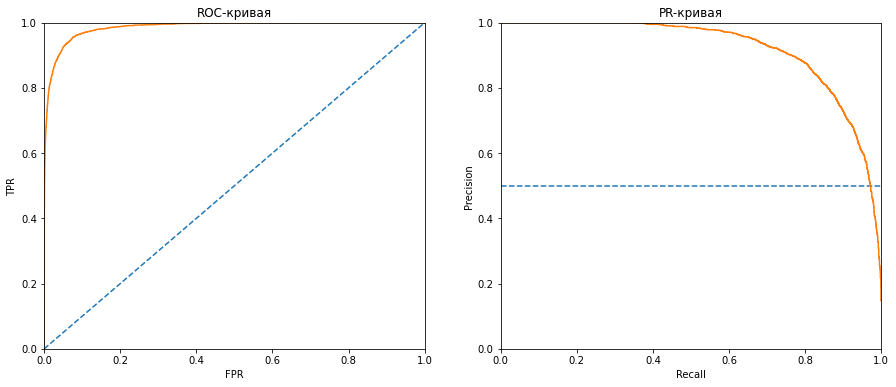

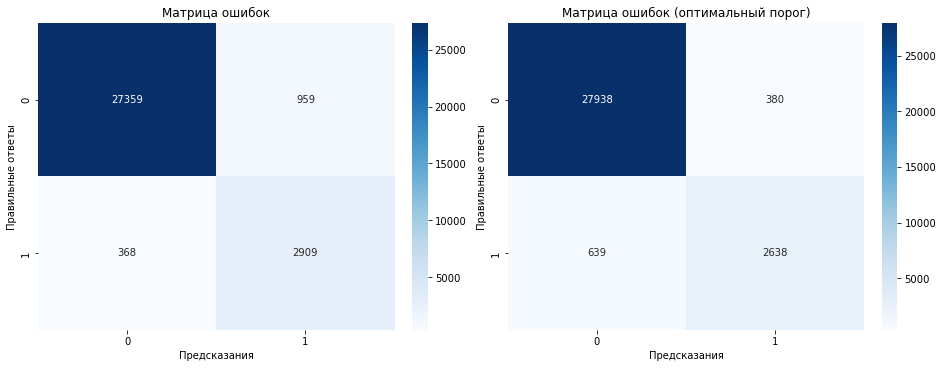

In [26]:
target_test = [label for label in df_test['toxic']]
best_threshold = visualize_tests(net, test_set)


Наша модель даже без дополнительного тюнинга соответствует условиям техзадания: метрика F1 на тестовой выборке порядка 0,8. С порогом по умолчанию у модели отличный recall: около 90% токсичных комментариев подсвечено! А вот precision оставляет желать лучшего: в 30% случаев тревога ложная.

Тем не менее, это поправимо. Анализ кривых позволяет выбрать оптимальный уровень "уверенности" в ответе для классификации: сбалансированный вариант лежит в пределах 12-20% ложных срабатываний и 20% упущенных случаев (метрика F1 достигает 0,84).

### Проверка произвольных текстов

В качестве иллюстрации реализуем проверку произвольных текстов c заданным порогом уверенности:

In [30]:
def classify(texts, threshold):
    inference_df = pd.DataFrame(data = {'text': texts, 'toxic': [np.nan]*len(texts)})
    inference_df['text'] = inference_df['text'].apply(clear_text)
    inference_set = MyDataset(inference_df)
    proba = net.predict_proba(inference_set)[:,1]
    for i in range (len(texts)):
        print (f'Текст: "{texts[i]}", ', end='')
        if proba[i] > threshold:
            print (f'вероятно, токсичен (уверенность {proba[i]:.0%}).')
        else:
            print (f'скорее всего, не токсичен.')

In [31]:
texts = ['I am here to lead you.',
         'Do not trifle with me, worm.',
         'Can no one offer me a challenge?!',
         'You rabble are undeserving of my presence.',
         'Weaklings! I will fight alongside you no longer.',
         'Take me to them, that I may render judgement.']

In [32]:
classify(texts, best_threshold)

Текст: "I am here to lead you.", скорее всего, не токсичен.
Текст: "Do not trifle with me, worm.", вероятно, токсичен (уверенность 82%).
Текст: "Can no one offer me a challenge?!", скорее всего, не токсичен.
Текст: "You rabble are undeserving of my presence.", вероятно, токсичен (уверенность 97%).
Текст: "Weaklings! I will fight alongside you no longer.", вероятно, токсичен (уверенность 86%).
Текст: "Take me to them, that I may render judgement.", скорее всего, не токсичен.


## Выводы

Мы подготовили данные, сбалансировали их и достроили модель BERT с помощью полносвязного слоя для классификации. По итогам обучения модель обеспечивает высокой показатель метрики (до 0,84 F1 с учетом оптимального порога классификации и 0,98-0,99 ROC_AUC) на тестовой выборке.

С практической точки зрения это означает, что:

- из действительно негативных комментариев модель способна детектировать не менее 80%;
- доля ложных срабатываний составит (в зависимости от ограничения на число токенов) от 12 до 20% от предсказаний положительного класса (или 2% от всех сообщений положительной тональности) - дополнительная нагрузка на модераторов не будет слишком высока.
- при необходимости метрика модели может быть легко подстроена под оптимальное соотношение точности и полноты исходя из оптимального порога степени уверенности в ответе, - к примеру, с незначительными изменениями можно применить взвешенную F-меру.